***
***

# **COVID-19 Vaccination Progress**

## *8) FB Prophet (Daily Vaccinations)*

***
***

## Table of Contents

| 1. INTRODUCTION | 2. Visualisations | 3. SUMMARY |
|----|----|----|
| *1.1 Dataset Characteristics* | *2.1 Importing Libraries and Data* | 3.1 Key Findings |
| | *2.2 FB Prophet Model* | 3.2 Next Steps |

***
***

## 1. INTRODUCTION

In this notebook we use the time series datasets (original annd detrended) generated in notebook 6 (Feature Selection for Prediction and Time Series Specific EDA) in a 

FBProphet -  modular regression model with interpretable parameters
linear regularised regression (L1 and L2 regularisation).
 periodic components and fits them with sine and cosine waves.
***

### 1.1 Dataset Characteristics

1) Our 3 timeseries (Worldwide, Germany & Israel) contain the following detrended feature:

| FEATURE | description | comment |
|----|----|----|
| **date** | data entry (13th December 2020 to 24th March 2021) | - |
| **daily_vaccinations_raw** | daily vaccinations as CHANGE COMPARED TO PREVIOUS DAY | calculation: total_vaccinations |
***
***

## 2. IMPORTS AND DATA PREPARATION

***

### 2.1 Importing Libraries and Data

+ Import numpy (linear algebra), pandas (data processing), visualisation libraries (matplotlib, seaborn, plotly), FB Prophet and metric calulations (sklearn).
+ Import datasets on COVID-19 vaccination progress from notebook 6.

In [1]:
#Import basic libraries
import numpy as np #linear algebra
import pandas as pd #data processing

#Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

#Facebook PROPHET
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

#Import libraries for statistics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

#Suppress pandas future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Plot settings
%matplotlib inline

In [2]:
#Import datasets
#Worldwide - daily vaccinations (raw)
df_wrld = pd.read_csv('data/df_wrld.csv', parse_dates=['date'])
df_wrld.sort_values('date', inplace=True)
df_wrld = df_wrld.set_index('date')
df_wrld.index.freq = 'd'

#Germany -  daily vaccinations (raw)
df_ger = pd.read_csv('data/df_ger.csv', parse_dates=['date'])
df_ger.sort_values('date', inplace=True)
df_ger = df_ger.set_index('date')

#Israel -  daily vaccinations (raw)
df_isr = pd.read_csv('data/df_isr.csv', parse_dates=['date'])
df_isr.sort_values('date', inplace=True)
df_isr = df_isr.set_index('date')

***

### 2.1 FB Prophet Model

In this section we investigate FBProphet for 3 timeseries (daily_vaccinations_raw --- worldwide, Germany, Israel). In order to apply an ARIMA model we need the timeseries to be trend-stationary, which we achieved in notebook 6.

n_changepoints is the number of change happen in the data. Prophet model detects them by its own. By default, its value is 25, which are uniformly placed in the first 80% of the time series. Changing n_changepoints can add value to the model.

changepoint_prior_scale to indicate how flexible the changepoints are allowed to be. In other words, how much can the changepoints fit to the data. If you make it high it will be more flexible, but you can end up overfitting. By default, this parameter is set to 0.05

seasonality_mode There are 2 types model seasonality mode. Additive & multiplicaticative. By default Prophet fits additive seasonalities, meaning the effect of the seasonality is added to the trend to get the forecast. Prophet can model multiplicative seasonality by setting seasonality_mode='multiplicative' in the model.

holiday_prior_scale just like changepoint_prior_scale, holiday_prior_scale is used to smoothning the effect of holidays. By default its value is 10, which provides very little regularization. Reducing this parameter dampens holiday effects

Seasonalities with fourier_order Prophet model, by default finds the seasonalities and adds the default parameters of the seasonality. We can modify the seasonalities effect by adding custom seasonalities as add_seasonality in the model with different fourier order.Yy default Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality.

Now, we will do the hyperparameters tuning using parametergrid. parametergrid will create all the possible parameters combination and will test the model prediction using every combination. I am taking 4 parameters: n_changepoints, changepoint_prior_scale,seasonality_mode, holiday_prior_scale for tuning.




Cross Validation

We can perform cross validation to measure forecast error. Cut off points are selected and we train the model with data up to that point. We can then compare the prediction vs actual data over a specified time horizon. This can be done using the cross_validation function. The parameter period specifies the interval between cut off points.




2.1 The Prophet Forecasting Model
The Prophet uses a decomposable time series model with three main model components: trend, seasonality, and holidays. They are combined in the following equation:
y(t)= g(t) + s(t) + h(t) + εt
g(t): piecewise linear or logistic growth curve for modeling non-periodic changes in time series
s(t): periodic changes (e.g. weekly/yearly seasonality)
h(t): effects of holidays (user provided) with irregular schedules
εt: error term accounts for any unusual changes not accommodated by the model
Using time as a regressor, Prophet is trying to fit several linear and non linear fu


#### **TASK 1**: Worldwide Daily Vaccinations (raw)

1) Split data into train and test
2) Train model and predict
3) Visualise results
4) Evaluation metrics

**KEY FINDINGS**

1) XXX

In [3]:
#Split data into train and test set
df_train, df_test = df_wrld[:'2021-03-14'].reset_index(), df_wrld['2021-03-15':].reset_index()

#Check the number of records in train and test
print(df_train.shape, df_test.shape)

(92, 2) (10, 2)


In [4]:
#Set date as index
df_train = df_train.set_index('date')
df_test = df_test.set_index('date')

#Drop any rows that contain zeros or are empty at the beginning of the series
df_train.replace([0], np.nan, inplace=True)
df_train.dropna(inplace=True)

In [5]:
#Reset index
df_train = df_train.reset_index()
df_test = df_test.reset_index()

#Relabel columns for FBProphet
df_train_fbp = df_train.rename({'date': 'ds', 'daily_vaccinations_raw': 'y'}, axis=1)
df_test_fbp = df_test.rename({'date': 'ds', 'daily_vaccinations_raw': 'y'}, axis=1)

In [6]:
#Forecasting with FB Prophet
#Define model
model = Prophet(growth='linear', #Not logistic as limit would be 2 x world/country population and way above what would ever be achiebed
                #changepoints=['2021-01-10', '2021-02-21'], #if manual changepoint setting desired
                n_changepoints=15,
                #changepoint_range=0.95, #Set to 95% of training data as only few datapoints availabel
                seasonality_mode='multiplicative', #Set to multiplicative to account for increasing seasonality effect over time
                #seasonality_prior_scale=20, #useful hyperparameter to explore further
                changepoint_prior_scale=0.5, #useful hyperparameter to tune in case of underfitting
                interval_width=0.95,
                yearly_seasonality=False,
                weekly_seasonality=True,
                daily_seasonality = False)

#Fit model
model.fit(df_train_fbp)

#Prediction for the next 10 days
future = model.make_future_dataframe(periods=10) # default frequency: daily
forecast=model.predict(future)

In [7]:
#Create dataframe of train/test and forecasted data
data = pd.concat([df_train_fbp,df_test_fbp])
verify = pd.merge(forecast, data, on='ds')

#Check original data versus forecast incl. ci
verify[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds').tail(10)

y          yhat    yhat_lower    yhat_upper
ds                                                              
2021-03-15   8580569.0  6.209275e+06  5.326537e+06  7.122301e+06
2021-03-16   7697723.0  7.238846e+06  6.399365e+06  8.199906e+06
2021-03-17   8621796.0  9.276526e+06  8.392099e+06  1.021828e+07
2021-03-18   9232608.0  1.039325e+07  9.470082e+06  1.129706e+07
2021-03-19  10122329.0  1.103266e+07  1.008293e+07  1.195105e+07
2021-03-20   9375708.0  9.865774e+06  8.896088e+06  1.079667e+07
2021-03-21   5478997.0  5.493849e+06  4.600327e+06  6.363186e+06
2021-03-22  11297560.0  7.166859e+06  6.277371e+06  8.123066e+06
2021-03-23  12236425.0  8.331144e+06  7.479941e+06  9.326538e+06
2021-03-24   7826562.0  1.064676e+07  9.581171e+06  1.163350e+07

In [8]:
#Correlation
print(verify.loc['2021-03-15':,['y','yhat']].corr())

            y     yhat
y     1.00000  0.94136
yhat  0.94136  1.00000


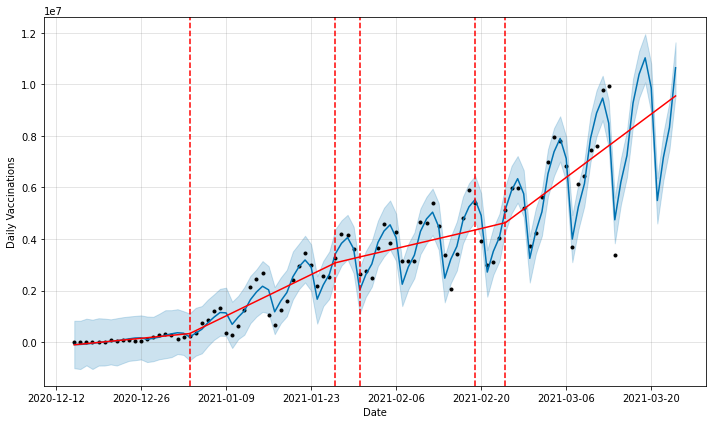

In [9]:
#Plot model
fig1 = model.plot(forecast, xlabel='Date', ylabel='Daily Vaccinations')
a = add_changepoints_to_plot(fig1.gca(),model,forecast) #optional or via fig2
fig1.set_figwidth(10)

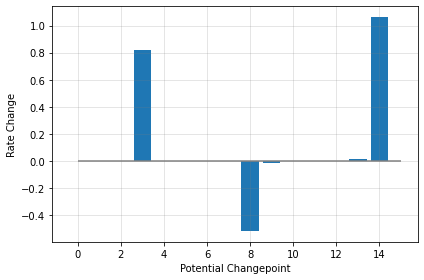

In [10]:
#Analyse potential changepoints
deltas = model.params['delta'].mean(0)

fig2 = plt.figure(facecolor='w')
ax = fig2.add_subplot(111)

ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate Change')
ax.set_xlabel('Potential Changepoint')
ax.hlines(y=0, xmin=0, xmax=15, color='grey')

fig2.tight_layout();

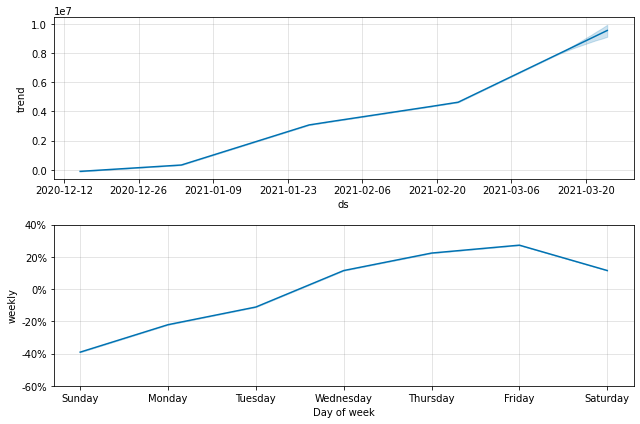

In [11]:
#Plot model components (in this case trend and weekly)
fig3 = model.plot_components(forecast)

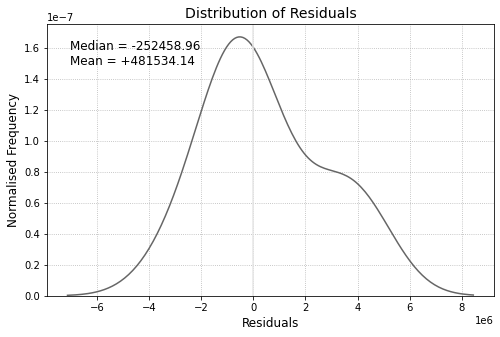

In [12]:
#Check distribution of residuals
#Calculate residuals
residuals=(verify.query('ds>="2021-03-15"')['y']) - (verify.query('ds>="2021-03-15"')['yhat'])

#Density plot
fig4, ax = plt.subplots(figsize=(8,5))

sns.kdeplot(residuals, ax=ax, color='0.4')

ax.grid(ls=':')
ax.set_xlabel('Residuals', fontsize=12)
ax.set_ylabel('Normalised Frequency', fontsize=12)
ax.axvline(0, color='0.9')
ax.set_title('Distribution of Residuals', fontsize=14)
ax.text(0.05, 0.85, 'Median = {:+1.2f} \nMean = {:+4.2f}'.format(
                                                                residuals.median(),
                                                                residuals.mean()),
                                                                fontsize=12,
                                                                transform=ax.transAxes);

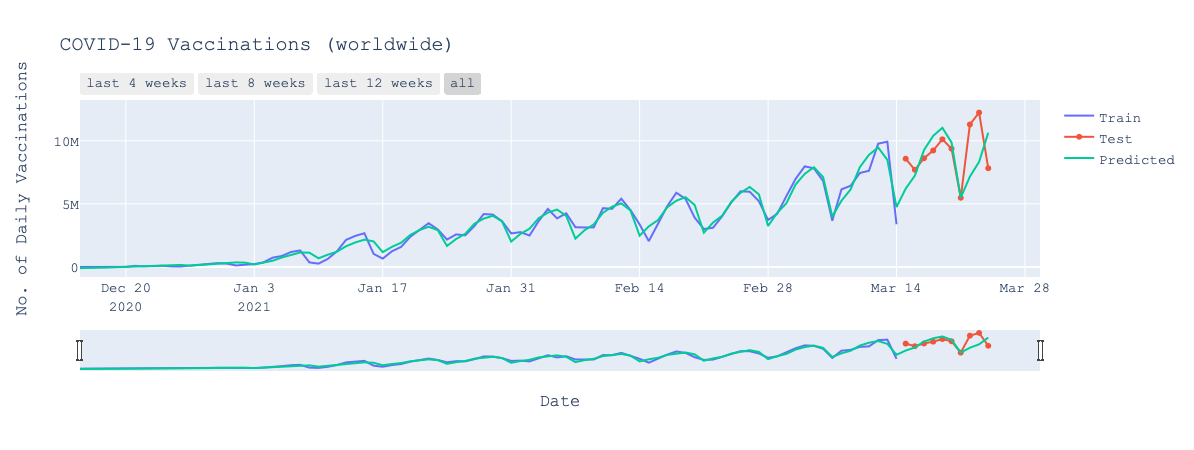

In [13]:
#Create Plotly plot of traces for original and predicted values
fig5 = go.Figure()

#Define traces for train/test and forecast
fig5.add_trace(go.Scatter(x=verify.query('ds<"2021-03-15"')['ds'], y=verify.query('ds<"2021-03-15"')['y'], name='Train'))
fig5.add_trace(go.Scatter(x=verify.query('ds>="2021-03-15"')['ds'], y=verify.query('ds>="2021-03-15"')['y'], name='Test'))
fig5.add_trace(go.Scatter(x=verify.ds, y=verify.yhat, name='Predicted'))

#Define range slider and time-span buttons
fig5.update_xaxes(
                rangeslider_visible=True,
                rangeselector=dict(
                    buttons=list([
                        dict(count=1, label='last 4 weeks', step='month', stepmode='backward'),
                        dict(count=2, label='last 8 weeks', step='month', stepmode='backward'),
                        dict(count=3, label='last 12 weeks', step='month', stepmode='backward'),
                        dict(step='all')
                        
                    ])
                )
)

#Define title and axis labels
fig5.update_layout(
    title="COVID-19 Vaccinations (worldwide)",
    xaxis_title='Date',
    yaxis_title='No. of Daily Vaccinations',
    font=dict(
        family='Courier New, monospace',
        size=14,
    )
)

fig5.show();

In [14]:
#Evaluation metrics for FBProphet model
r2 = r2_score(verify.query('ds>="2021-03-15"')['y'], verify.query('ds>="2021-03-15"')['yhat'])
mae = mean_absolute_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'])
rmse = mean_squared_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'], squared=False)
mape = mean_absolute_percentage_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'])

print('====='*10)
print(f'The metrics for the global FBProphet model are:')
print('====='*10)
print(f'R2 score: {round(r2,2)}')
print(f'MAE score: {round(mae,2)}')
print(f'RMSE score: {round(rmse,2)}')
print(f'MAPE score: {round(mape,2)}')
print('====='*10)

The metrics for the global FBProphet model are:
R2 score: -0.48
MAE score: 1691696.58
RMSE score: 2212371.35
MAPE score: 0.17


 if the fit is actually worse than just fitting a horizontal line then R-square is negative.

800 days total dataset
initial = 624 == size of train dataset
horizon = 20 == size to be forecasted
period = 10 (default = 1/2 of horizon) == spacing between cutoff dates as incremental

1st Iteration: Train on 1-624, Forecast for 625-644
2nd Iteration: Train on 11-634, Forecast for 635-654
3rd Iteration: Train on 21-644, Forecast for 645-664

In [15]:
#cross validation
cross_v = cross_validation(model, horizon = '7 days', initial='40 days', disable_tqdm=True) #period: how much data to add for each training cycle
perf = performance_metrics(cross_v)
perf

INFO:prophet:Making 13 forecasts with cutoffs between 2021-01-24 00:00:00 and 2021-03-07 00:00:00


horizon           mse          rmse            mae      mape  \
0  1 days 00:00:00  6.944434e+11  8.333327e+05  643313.825203  0.191925   
1  1 days 12:00:00  6.540254e+11  8.087184e+05  624017.909524  0.159599   
2  2 days 00:00:00  5.460473e+11  7.389502e+05  549545.393922  0.127900   
3  2 days 12:00:00  3.948756e+11  6.283913e+05  497638.935432  0.110512   
4  3 days 00:00:00  4.005597e+11  6.328979e+05  486659.976715  0.100449   
5  3 days 12:00:00  2.495472e+11  4.995470e+05  406910.072567  0.109362   
6  4 days 00:00:00  5.699025e+11  7.549189e+05  590987.810901  0.107472   
7  4 days 12:00:00  9.037398e+11  9.506523e+05  726913.428338  0.186901   
8  5 days 00:00:00  9.824526e+11  9.911875e+05  809967.332395  0.169673   
9  5 days 12:00:00  8.464632e+11  9.200344e+05  733814.105012  0.156481   
10 6 days 00:00:00  1.313593e+12  1.146121e+06  851178.047962  0.149145   
11 6 days 12:00:00  8.436081e+11  9.184814e+05  636813.113414  0.112009   
12 7 days 00:00:00  4.911555e+11  7.008249e+05  510861.668222  0.144831   

       mdape     smape  coverage  
0   0.110979  0.186030  0.481481  
1   0.087327  0.148863  0.587302  
2   0.042973  0.127795  0.592593  
3   0.113519  0.111416  0.634921  
4   0.095718  0.100312  0.703704  
5   0.150358  0.108695  0.904762  
6   0.051069  0.105482  0.555556  
7   0.131409  0.173141  0.476190  
8   0.082184  0.156887  0.444444  
9   0.082611  0.155343  0.476190  
10  0.094100  0.155569  0.444444  
11  0.214254  0.114340  0.587302  
12  0.080453  0.135846  0.592593

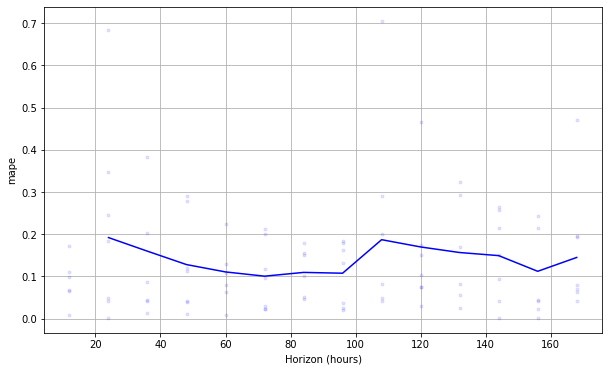

In [16]:
plot_cross_validation_metric(cross_v, 'mape');

#### **TASK 2**: Daily Vaccinations (raw) (Germany)

1) Split data into train and test
2) Train model and predict
3) Visualise results
4) Evaluation metrics

**KEY FINDINGS**

1) XXX

In [17]:
#Split data into train and test set
df_train, df_test = df_ger[:'2021-03-14'].reset_index(), df_ger['2021-03-15':].reset_index()

#Check the number of records in train and test
print(df_train.shape, df_test.shape)

(92, 2) (10, 2)


In [18]:
#Set date as index
df_train = df_train.set_index('date')
df_test = df_test.set_index('date')

#Drop any rows that contain zeros or are empty at the beginning of the series
df_train.replace([0], np.nan, inplace=True)
df_train.dropna(inplace=True)

#Drop any rows that contain zeros or are empty at the end of the series
df_train.replace([0], np.nan, inplace=True)
df_train.dropna(inplace=True)

In [19]:
#Reset index
df_train = df_train.reset_index()
df_test = df_test.reset_index()

#Relabel columns for FBProphet
df_train_fbp = df_train.rename({'date': 'ds', 'daily_vaccinations_raw_germany': 'y'}, axis=1)
df_test_fbp = df_test.rename({'date': 'ds', 'daily_vaccinations_raw_germany': 'y'}, axis=1)

In [20]:
#Forecasting with FB Prophet
#Define model
model = Prophet(growth='linear', #Not logistic as limit would be 2 x world/country population and way above what would ever be achiebed
                #changepoints=['2021-01-10', '2021-02-21'], #if manual changepoint setting desired
                n_changepoints=15,
                #changepoint_range=0.95, #Set to 95% of training data as only few datapoints availabel
                seasonality_mode='multiplicative', #Set to multiplicative to account for increasing seasonality effect over time
                #seasonality_prior_scale=20, #useful hyperparameter to explore further
                #changepoint_prior_scale=0.2, #useful hyperparameter to explore further
                interval_width=0.95,
                yearly_seasonality=False,
                weekly_seasonality=True,
                daily_seasonality = False)

#Fit model
model.fit(df_train_fbp)

#Prediction for the next 9 days (as no data reported for 24th March at this point in time)
future = model.make_future_dataframe(periods=9) # default frequency: daily
forecast=model.predict(future)

In [21]:
#Create dataframe of train/test and forecasted data
data = pd.concat([df_train_fbp,df_test_fbp])
verify = pd.merge(forecast, data, on='ds')

#Check original data versus forecast incl. ci
verify[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds').tail(10)

y           yhat     yhat_lower     yhat_upper
ds                                                               
2021-03-14  165580.0  161698.980465  144604.254971  178274.893189
2021-03-15  234063.0  269999.554010  252873.454954  287446.500275
2021-03-16  177909.0  297760.780303  281430.237081  314624.376790
2021-03-17  208570.0  336603.884017  318442.094793  354145.003565
2021-03-18  189173.0  329449.142357  311669.401113  348225.275633
2021-03-19  228125.0  345906.001239  328395.248682  363543.681843
2021-03-20  206690.0  264734.513160  246853.145424  281381.674494
2021-03-21  164604.0  186781.838683  167047.868955  204745.714183
2021-03-22  260116.0  310974.073047  293100.069660  330163.549471
2021-03-23  268295.0  341989.417483  323760.421146  363001.327861

In [22]:
#Correlation
print(verify.loc['2021-03-15':,['y','yhat']].corr())

             y      yhat
y     1.000000  0.908548
yhat  0.908548  1.000000


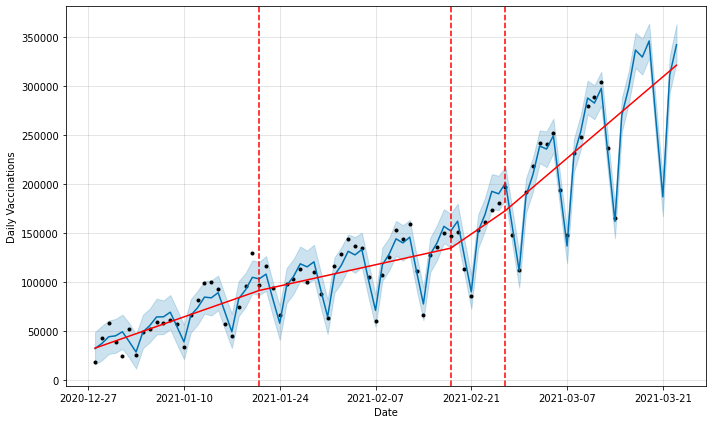

In [23]:
#Plot model
fig1 = model.plot(forecast, xlabel='Date', ylabel='Daily Vaccinations')
a = add_changepoints_to_plot(fig1.gca(),model,forecast) #optional or via fig2
fig1.set_figwidth(10)

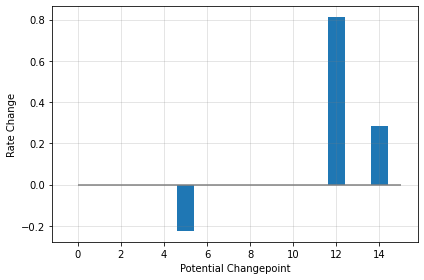

In [24]:
#Analyse potential changepoints
deltas = model.params['delta'].mean(0)

fig2 = plt.figure(facecolor='w')
ax = fig2.add_subplot(111)

ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate Change')
ax.set_xlabel('Potential Changepoint')
ax.hlines(y=0, xmin=0, xmax=15, color='grey')

fig2.tight_layout();

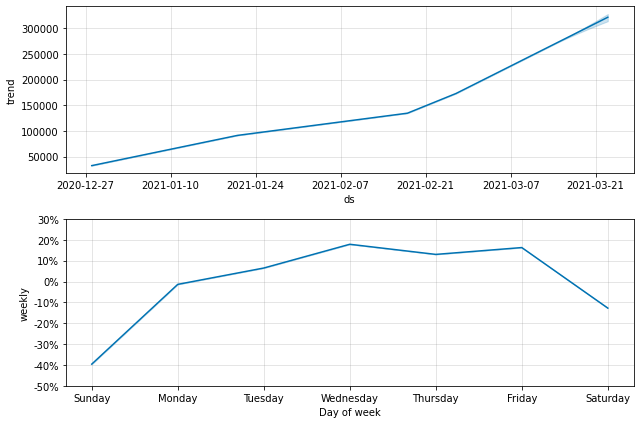

In [25]:
#Plot model components (in this case trend and weekly)
fig3 = model.plot_components(forecast)

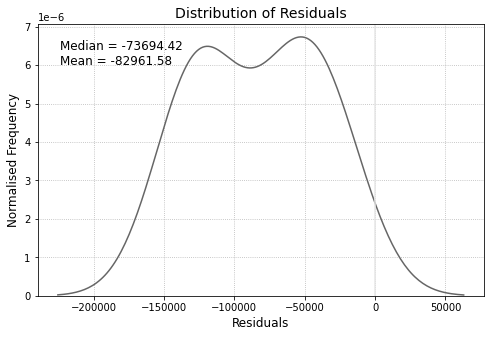

In [26]:
#Check distribution of residuals
#Calculate residuals
residuals=(verify.query('ds>="2021-03-15"')['y']) - (verify.query('ds>="2021-03-15"')['yhat'])

#Density plot
fig4, ax = plt.subplots(figsize=(8,5))

sns.kdeplot(residuals, ax=ax, color='0.4')

ax.grid(ls=':')
ax.set_xlabel('Residuals', fontsize=12)
ax.set_ylabel('Normalised Frequency', fontsize=12)
ax.axvline(0, color='0.9')
ax.set_title('Distribution of Residuals', fontsize=14)
ax.text(0.05, 0.85, 'Median = {:+1.2f} \nMean = {:+4.2f}'.format(
                                                                residuals.median(),
                                                                residuals.mean()),
                                                                fontsize=12,
                                                                transform=ax.transAxes);

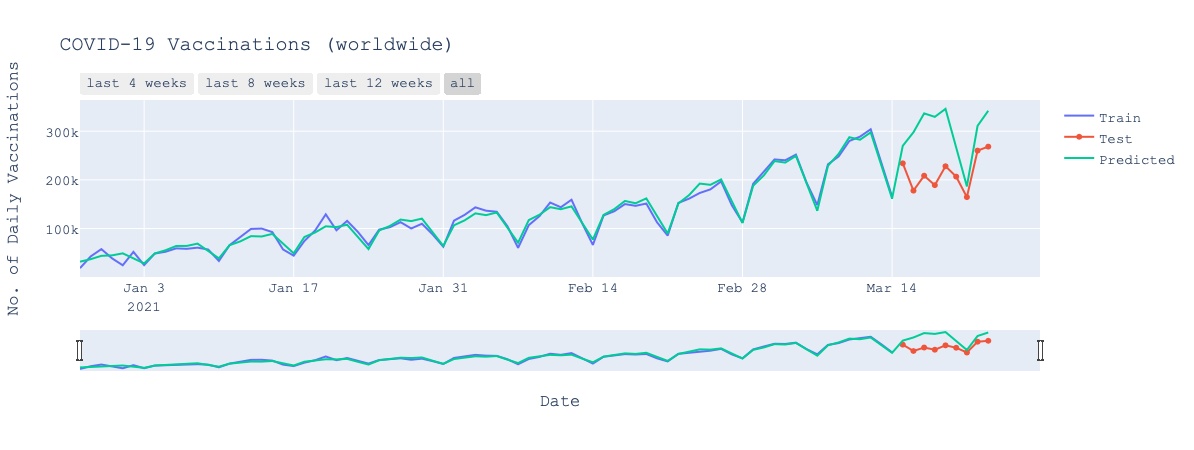

In [27]:
#Create Plotly plot of traces for original and predicted values
fig5 = go.Figure()

#Define traces for train/test and forecast
fig5.add_trace(go.Scatter(x=verify.query('ds<"2021-03-15"')['ds'], y=verify.query('ds<"2021-03-15"')['y'], name='Train'))
fig5.add_trace(go.Scatter(x=verify.query('ds>="2021-03-15"')['ds'], y=verify.query('ds>="2021-03-15"')['y'], name='Test'))
fig5.add_trace(go.Scatter(x=verify.ds, y=verify.yhat, name='Predicted'))

#Define range slider and time-span buttons
fig5.update_xaxes(
                rangeslider_visible=True,
                rangeselector=dict(
                    buttons=list([
                        dict(count=1, label='last 4 weeks', step='month', stepmode='backward'),
                        dict(count=2, label='last 8 weeks', step='month', stepmode='backward'),
                        dict(count=3, label='last 12 weeks', step='month', stepmode='backward'),
                        dict(step='all')
                        
                    ])
                )
)

#Define title and axis labels
fig5.update_layout(
    title="COVID-19 Vaccinations (worldwide)",
    xaxis_title='Date',
    yaxis_title='No. of Daily Vaccinations',
    font=dict(
        family='Courier New, monospace',
        size=14,
    )
)

fig5.show();

In [28]:
#Evaluation metrics for FBProphet model
r2 = r2_score(verify.query('ds>="2021-03-15"')['y'], verify.query('ds>="2021-03-15"')['yhat'])
mae = mean_absolute_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'])
rmse = mean_squared_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'], squared=False)
mape = mean_absolute_percentage_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'])

print('====='*10)
print(f'The metrics for the global FBProphet model are:')
print('====='*10)
print(f'R2 score: {round(r2,2)}')
print(f'MAE score: {round(mae,2)}')
print(f'RMSE score: {round(rmse,2)}')
print(f'MAPE score: {round(mape,2)}')
print('====='*10)

The metrics for the global FBProphet model are:
R2 score: -6.67
MAE score: 82961.58
RMSE score: 92782.15
MAPE score: 0.4


#### **TASK 2**: Daily Vaccinations (raw) (Israel)

1) Split data into train and test
2) Train model and predict
3) Visualise results
4) Evaluation metrics

**KEY FINDINGS**

1) XXX

In [29]:
#Split data into train and test set
df_train, df_test = df_isr[:'2021-03-14'].reset_index(), df_isr['2021-03-15':].reset_index()

#Check the number of records in train and test
print(df_train.shape, df_test.shape)

(92, 2) (10, 2)


In [30]:
#Set date as index
df_train = df_train.set_index('date')
df_test = df_test.set_index('date')

#Drop any rows that contain zeros or are empty at the beginning of the series
df_train.replace([0], np.nan, inplace=True)
df_train.dropna(inplace=True)

#Drop any rows that contain zeros or are empty at the end of the series
df_train.replace([0], np.nan, inplace=True)
df_train.dropna(inplace=True)

In [31]:
#Reset index
df_train = df_train.reset_index()
df_test = df_test.reset_index()

#Relabel columns for FBProphet
df_train_fbp = df_train.rename({'date': 'ds', 'daily_vaccinations_raw_israel': 'y'}, axis=1)
df_test_fbp = df_test.rename({'date': 'ds', 'daily_vaccinations_raw_israel': 'y'}, axis=1)

In [32]:
#Forecasting with FB Prophet
#Define model
model = Prophet(growth='linear', #Not logistic as limit would be 2 x world/country population and way above what would ever be achiebed
                #changepoints=['2021-01-10', '2021-02-21'], #if manual changepoint setting desired
                n_changepoints=15,
                #changepoint_range=0.95, #Set to 95% of training data as only few datapoints availabel
                seasonality_mode='multiplicative', #Set to multiplicative to account for increasing seasonality effect over time
                #seasonality_prior_scale=20, #useful hyperparameter to explore further
                changepoint_prior_scale=0.5, #useful hyperparameter to tune in case of underfitting
                interval_width=0.95,
                yearly_seasonality=False,
                weekly_seasonality=True,
                daily_seasonality = False)

#Fit model
model.fit(df_train_fbp)

#Prediction for the next 9 days (as no data reported for 24th March at this point in time)
future = model.make_future_dataframe(periods=9) # default frequency: daily
forecast=model.predict(future)

In [33]:
#Create dataframe of train/test and forecasted data
data = pd.concat([df_train_fbp,df_test_fbp])
verify = pd.merge(forecast, data, on='ds')

#Check original data versus forecast incl. ci
verify[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds').tail(10)

y           yhat     yhat_lower     yhat_upper
ds                                                               
2021-03-14  282381.0  220752.737760  129642.725089  315513.387425
2021-03-15  440051.0  257522.464194  160475.707763  352123.700905
2021-03-16  529119.0  321032.765353  229213.854193  407602.773488
2021-03-17  581855.0  382705.190806  288566.225603  478113.285499
2021-03-18  660276.0  419591.197601  326059.776698  511597.722837
2021-03-19  740655.0  449056.490735  360046.925344  548339.884804
2021-03-20  844285.0  450069.881076  358386.881339  541426.005113
2021-03-21  419618.0  217910.184497  119717.953698  313660.879343
2021-03-22  412197.0  254200.329312  157872.973618  344844.076910
2021-03-23  494805.0  316883.677740  216916.475563  411442.183625

In [34]:
#Correlation
print(verify.loc['2021-03-15':,['y','yhat']].corr())

             y      yhat
y     1.000000  0.666684
yhat  0.666684  1.000000


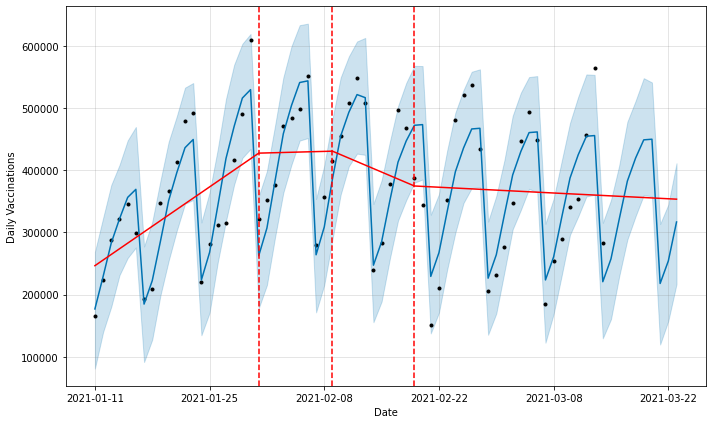

In [35]:
#Plot model
fig1 = model.plot(forecast, xlabel='Date', ylabel='Daily Vaccinations')
a = add_changepoints_to_plot(fig1.gca(),model,forecast) #optional or via fig2
fig1.set_figwidth(10)

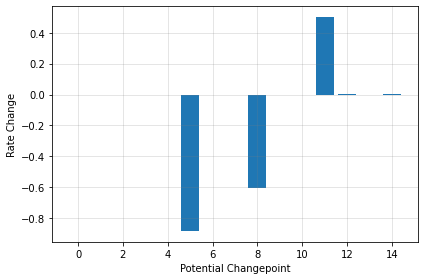

In [36]:
#Analyse potential changepoints
deltas = model.params['delta'].mean(0)

fig2 = plt.figure(facecolor='w')
ax = fig2.add_subplot(111)

ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate Change')
ax.set_xlabel('Potential Changepoint')

fig2.tight_layout();

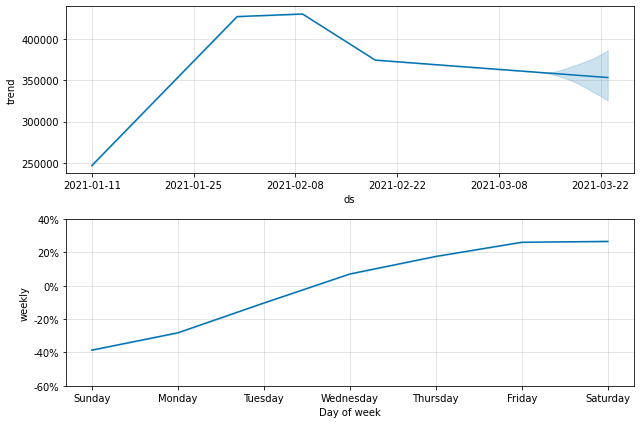

In [37]:
#Plot model components (in this case trend and weekly)
fig3 = model.plot_components(forecast)

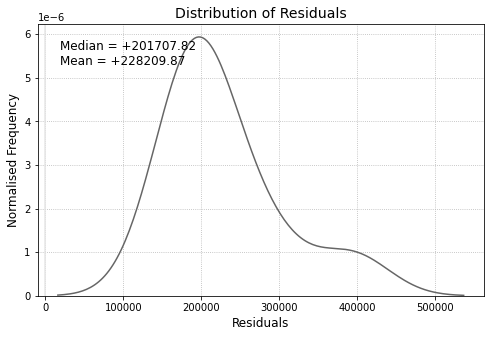

In [38]:
#Check distribution of residuals
#Calculate residuals
residuals=(verify.query('ds>="2021-03-15"')['y']) - (verify.query('ds>="2021-03-15"')['yhat'])

#Density plot
fig4, ax = plt.subplots(figsize=(8,5))

sns.kdeplot(residuals, ax=ax, color='0.4')

ax.grid(ls=':')
ax.set_xlabel('Residuals', fontsize=12)
ax.set_ylabel('Normalised Frequency', fontsize=12)
ax.axvline(0, color='0.9')
ax.set_title('Distribution of Residuals', fontsize=14)
ax.text(0.05, 0.85, 'Median = {:+1.2f} \nMean = {:+4.2f}'.format(
                                                                residuals.median(),
                                                                residuals.mean()),
                                                                fontsize=12,
                                                                transform=ax.transAxes);

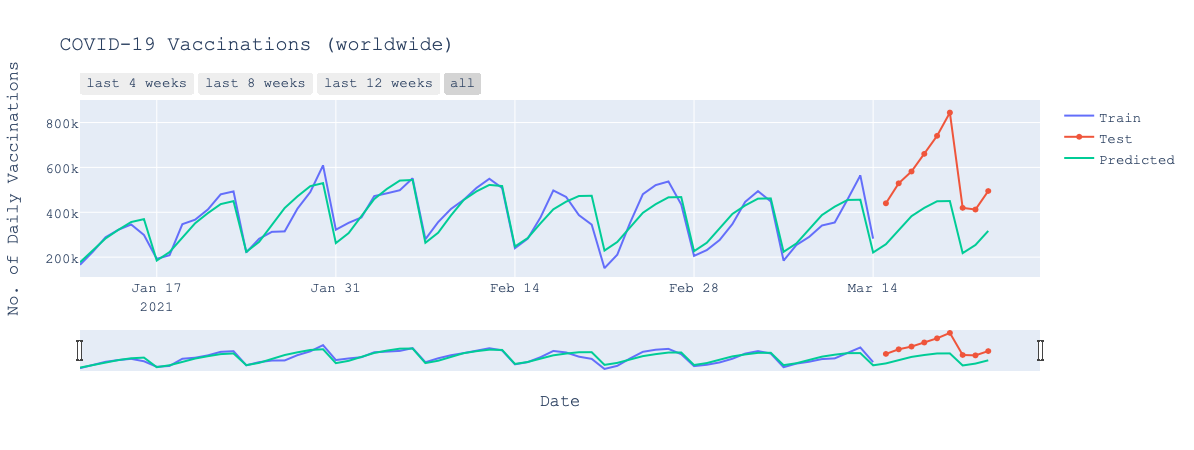

In [39]:
#Create Plotly plot of traces for original and predicted values
fig5 = go.Figure()

#Define traces for train/test and forecast
fig5.add_trace(go.Scatter(x=verify.query('ds<"2021-03-15"')['ds'], y=verify.query('ds<"2021-03-15"')['y'], name='Train'))
fig5.add_trace(go.Scatter(x=verify.query('ds>="2021-03-15"')['ds'], y=verify.query('ds>="2021-03-15"')['y'], name='Test'))
fig5.add_trace(go.Scatter(x=verify.ds, y=verify.yhat, name='Predicted'))

#Define range slider and time-span buttons
fig5.update_xaxes(
                rangeslider_visible=True,
                rangeselector=dict(
                    buttons=list([
                        dict(count=1, label='last 4 weeks', step='month', stepmode='backward'),
                        dict(count=2, label='last 8 weeks', step='month', stepmode='backward'),
                        dict(count=3, label='last 12 weeks', step='month', stepmode='backward'),
                        dict(step='all')
                        
                    ])
                )
)

#Define title and axis labels
fig5.update_layout(
    title="COVID-19 Vaccinations (worldwide)",
    xaxis_title='Date',
    yaxis_title='No. of Daily Vaccinations',
    font=dict(
        family='Courier New, monospace',
        size=14,
    )
)

fig5.show();

In [40]:
#Evaluation metrics for FBProphet model
r2 = r2_score(verify.query('ds>="2021-03-15"')['y'], verify.query('ds>="2021-03-15"')['yhat'])
mae = mean_absolute_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'])
rmse = mean_squared_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'], squared=False)
mape = mean_absolute_percentage_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'])

print('====='*10)
print(f'The metrics for the global FBProphet model are:')
print('====='*10)
print(f'R2 score: {round(r2,2)}')
print(f'MAE score: {round(mae,2)}')
print(f'RMSE score: {round(rmse,2)}')
print(f'MAPE score: {round(mape,2)}')
print('====='*10)

The metrics for the global FBProphet model are:
R2 score: -1.78
MAE score: 228209.87
RMSE score: 238501.48
MAPE score: 0.4


***
***
***

In [41]:
#Measure forecast error using historical data
#Perform cross-validation to automatically valida for selected historical cut-offs
#By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon

#cv = cross_validation(model=model, horizon= '10 days', initial='30 days') #Forecast horizon, initial training period and spacing between cutoff dates (period)

#cv #yhat_lower/yhat_upper - confidence intterval

In [42]:
#Performance metrics, mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE),
#mean absolute percent error (MAPE), median absolute percent error (MDAPE) 

#df_perf = performance_metrics(cv)
#df_perf

In [43]:
#Vizualisation: Dots = absolute percent error for each prediction; blue line = MAPE, mean over a rolling window of the dots

#fig3 = plot_cross_validation_metric(cv, metric='mape')

***
***
***

In [44]:
df_tweets = pd.read_csv('data/global_vacc_senti.csv', parse_dates=['date'])
df_tweets.sort_values('date', inplace=True)
df_tweets = df_tweets.set_index('date')
df_tweets = df_tweets[['negative', 'neutral', 'positive']]
df_tweets.fillna(0, inplace=True)
df_tweets.tail()

negative  neutral  positive
date                                   
2021-03-20      30.0     62.0      94.0
2021-03-21      22.0     49.0      40.0
2021-03-22      14.0     65.0      58.0
2021-03-23      23.0     63.0      38.0
2021-03-24      21.0     65.0      63.0

In [45]:
df_tweets['lag_7_neg'] = df_tweets['negative'].shift(3)
df_tweets['lag_7_neu'] = df_tweets['neutral'].shift(3)
df_tweets['lag_7_pos'] = df_tweets['positive'].shift(3)
#df_fbp = df_tweets
#df_fbp.head()

#Drop all rows with NaNs in 'daily_vaccinations'
#df_fbp.dropna(subset = ['lag_7_vac', 'lag_7_neu', 'lag_7_neg', 'lag_7_pos'], axis = 0, how = 'any', inplace = True)

#df_fbp = df_fbp[['lag_7_vac', 'lag_7_neu', 'lag_7_neg', 'lag_7_pos']]

#df_fbp.head()

In [46]:
df_tweets_isr = pd.merge(df_isr, df_tweets, on='date')
df_tweets_isr.head()

daily_vaccinations_raw_israel  negative  neutral  positive  \
date                                                                     
2020-12-13                            NaN       0.0      6.0       4.0   
2020-12-14                            NaN       1.0      7.0       6.0   
2020-12-15                            NaN       1.0      7.0       5.0   
2020-12-16                            NaN       4.0      2.0       2.0   
2020-12-17                            NaN       1.0      4.0       2.0   

            lag_7_neg  lag_7_neu  lag_7_pos  
date                                         
2020-12-13        NaN        NaN        NaN  
2020-12-14        NaN        NaN        NaN  
2020-12-15        NaN        NaN        NaN  
2020-12-16        0.0        6.0        4.0  
2020-12-17        1.0        7.0        6.0

In [47]:
#Drop any rows that contain zeros or are empty at the beginning of the series (i.e. in train)
df_tweets_isr.replace([0], np.nan, inplace=True)
df_tweets_isr.dropna(inplace=True, how='any')
df_tweets_isr.head()

daily_vaccinations_raw_israel  negative  neutral  positive  \
date                                                                     
2021-01-11                       165844.0       1.0      2.0       4.0   
2021-01-14                       321951.0       1.0      4.0       3.0   
2021-01-16                       298751.0       5.0      6.0       2.0   
2021-01-17                       192346.0       5.0      9.0       6.0   
2021-01-18                       208641.0       1.0      2.0       5.0   

            lag_7_neg  lag_7_neu  lag_7_pos  
date                                         
2021-01-11        2.0        5.0        5.0  
2021-01-14        1.0        2.0        4.0  
2021-01-16        1.0        6.0        6.0  
2021-01-17        1.0        4.0        3.0  
2021-01-18        4.0        3.0        6.0

In [48]:
#Split data into train and test set
df_train, df_test = df_tweets_isr[:'2021-03-14'].reset_index(), df_tweets_isr['2021-03-15':].reset_index()

#Check the number of records in train and test
print(df_train.shape, df_test.shape)

(44, 8) (9, 8)


In [49]:
#Set date as index
df_train = df_train.set_index('date')
df_test = df_test.set_index('date')

#Drop any rows that contain zeros or are empty at the beginning of the series (i.e. in train)
#df_train.replace([0], np.nan, inplace=True)
#df_train.dropna(inplace=True)

In [50]:
#Reset index
df_train = df_train.reset_index()
df_test = df_test.reset_index()

#Relabel columns for forecasting
df_train_fbp = df_train.rename({'date': 'ds', 'daily_vaccinations_raw_israel': 'y'}, axis=1)
df_test_fbp = df_test.rename({'date': 'ds', 'daily_vaccinations_raw_israel': 'y'}, axis=1)

In [51]:
df_train_fbp.head()

ds         y  negative  neutral  positive  lag_7_neg  lag_7_neu  \
0 2021-01-11  165844.0       1.0      2.0       4.0        2.0        5.0   
1 2021-01-14  321951.0       1.0      4.0       3.0        1.0        2.0   
2 2021-01-16  298751.0       5.0      6.0       2.0        1.0        6.0   
3 2021-01-17  192346.0       5.0      9.0       6.0        1.0        4.0   
4 2021-01-18  208641.0       1.0      2.0       5.0        4.0        3.0   

   lag_7_pos  
0        5.0  
1        4.0  
2        6.0  
3        3.0  
4        6.0

In [52]:
#Forecasting with FB Prophet
#Define and fit model
model = Prophet(growth='linear', #Not logistic as limit would be 2 x world/country population and way above what would ever be achiebed
                #changepoints=['2021-01-10', '2021-02-21'], #if manual changepoint setting desired
                n_changepoints=15,
                seasonality_mode='multiplicative', #Set to multiplicative to account for increasing seasonality effect over time
                interval_width=0.95,
                yearly_seasonality=False,
                weekly_seasonality=True,
                daily_seasonality = False)

#Prophet cannot handle multivariate features - add regressor
model.add_regressor('lag_7_pos', standardize='False') #Additive is default, can also add mode='multiplicative'
model.add_regressor('lag_7_neg', standardize='False') #Additive is default
model.add_regressor('lag_7_neu', standardize='False') #Additive is default

#Fit model
model.fit(df_train_fbp)

#Create future dataframe for next 10 days
future = model.make_future_dataframe(periods=9) #Default frequency: daily

#Add additional features to future dataframe
future['lag_7_pos'] = df_tweets_isr.reset_index().lag_7_pos
future['lag_7_neg'] = df_tweets_isr.reset_index().lag_7_neg
future['lag_7_neu'] = df_tweets_isr.reset_index().lag_7_neu

#Predict future dataframe
forecast=model.predict(future)

In [53]:
forecast[['ds', 'yhat', 'yhat_lower']].tail()

ds           yhat     yhat_lower
48 2021-03-19  480257.526040  348587.723169
49 2021-03-20  474374.767876  336470.813831
50 2021-03-21  245229.252897  111704.554523
51 2021-03-22  271587.911155  126205.449733
52 2021-03-23  442223.213118  310931.137304

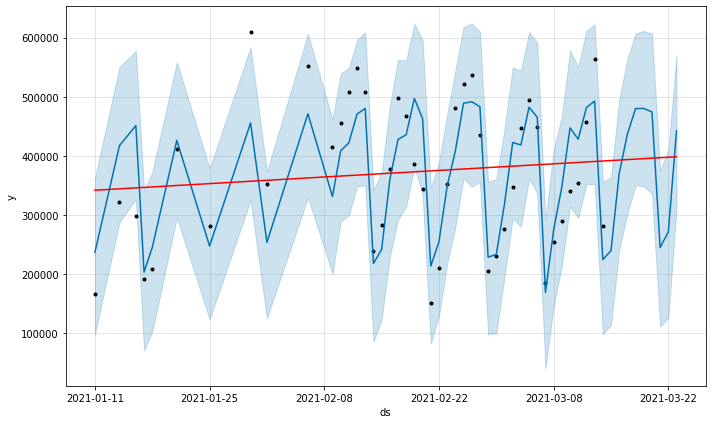

In [54]:
#Plot model forecast
fig1 = model.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(),model,forecast)

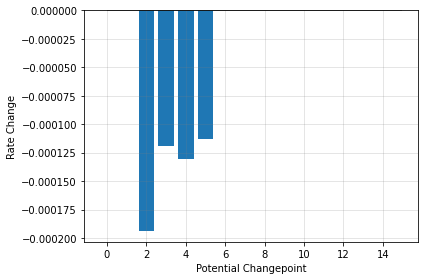

In [55]:
#Analyse for potential changepoints
deltas = model.params['delta'].mean(0)

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)

ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate Change')
ax.set_xlabel('Potential Changepoint')

#Add horizontal line
ax.hlines(y=0, xmin=-0, xmax=15, color='grey')



fig.tight_layout();

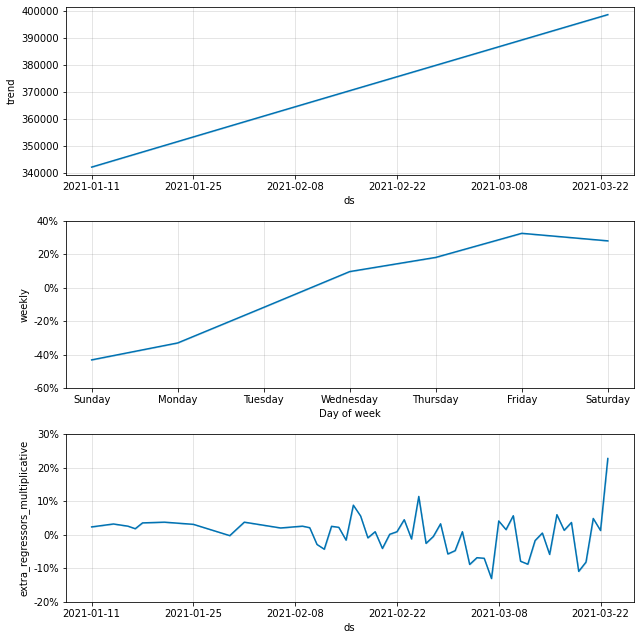

In [56]:
#Plot model components (trend and weekly)
fig2 = model.plot_components(forecast)

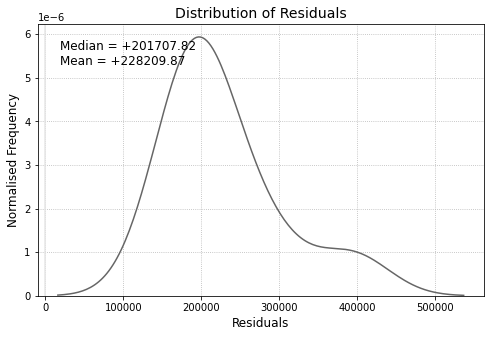

In [57]:
#RESIDUALS
residuals=(verify.query('ds>="2021-03-15"')['y']) - (verify.query('ds>="2021-03-15"')['yhat'])

f, ax = plt.subplots(figsize=(8,5))

sns.kdeplot(residuals, ax=ax, color='0.4')

ax.grid(ls=':')
ax.set_xlabel('Residuals', fontsize=12)
ax.set_ylabel('Normalised Frequency', fontsize=12)
ax.axvline(0, color='0.9')
ax.set_title('Distribution of Residuals', fontsize=14)

ax.text(0.05, 0.85, 'Median = {:+1.2f} \nMean = {:+4.2f}'.format(
                                                                residuals.median(),
                                                                residuals.mean()),
                                                                fontsize=12,
                                                                transform=ax.transAxes);

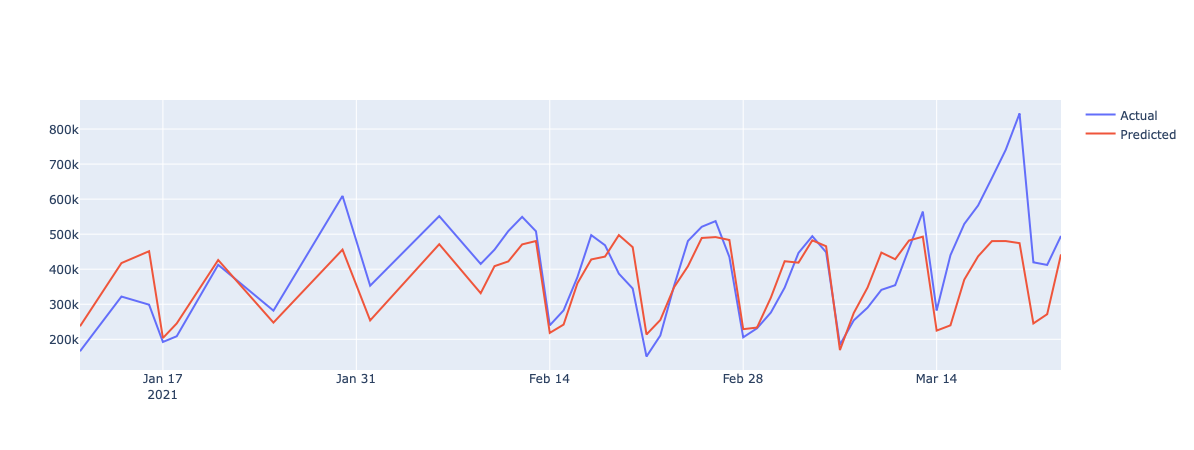

In [58]:
#Plot of original and predicted values
#Create dataframe of train/test and forecasted data
data = pd.concat([df_train_fbp,df_test_fbp])
verify = pd.merge(forecast, data, on='ds')

#Create Plotly plot of traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=verify.query('ds>="2021-01-01"')['ds'], y=verify.query('ds>="2021-01-01"')['y'], name='Actual',))
fig.add_trace(go.Scatter(x=verify.query('ds>="2021-01-01"')['ds'], y=verify.query('ds>="2021-01-01"')['yhat'], name='Predicted',))

fig.show();

In [59]:
#Evaluation metrics for FBProphet model
r2 = r2_score(verify.query('ds>="2021-03-15"')['y'], verify.query('ds>="2021-03-15"')['yhat'])
mae = mean_absolute_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'])
rmse = mean_squared_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'], squared=False)
mape = mean_absolute_percentage_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'])

print('====='*10)
print(f'The metrics for the global FBProphet model are:')
print('====='*10)
print(f'R2 score: {round(r2,2)}')
print(f'MAE score: {round(mae,2)}')
print(f'RMSE score: {round(rmse,2)}')
print(f'MAPE score: {round(mape,2)}')
print('====='*10)

The metrics for the global FBProphet model are:
R2 score: -1.04
MAE score: 186917.23
RMSE score: 204513.39
MAPE score: 0.33
